In [1]:
import matplotlib.pylab as pl
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import numpy.linalg as la
import pickle
import random
import time

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


### Problem 2 A Normalize Data
    Please refer to normalize_data.py.

In [2]:
X, Y = pickle.load(open('normalized_data', 'rb'))
N, D = X.shape
X_mean, X_std, Y_mean, Y_std = pickle.load(open('statistics', 'rb'))

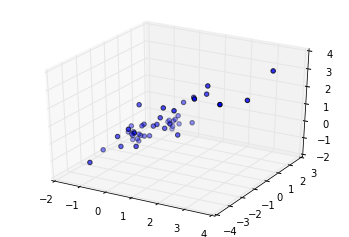

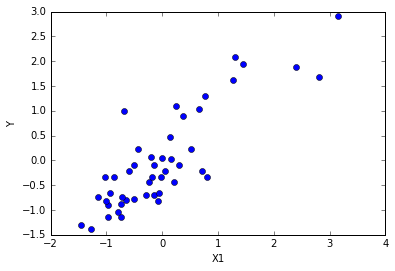

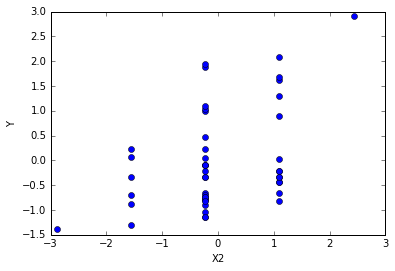

In [3]:
# plot normalized data
figure = pl.figure()
axis = figure.gca(projection='3d')
axis.scatter(X[:, 0], X[:, 1], Y)
pl.figure()
pl.plot(X[:, 0], Y, 'bo')
pl.xlabel('X1')
pl.ylabel('Y')
pl.figure()
pl.plot(X[:, 1], Y, 'bo')
pl.xlabel('X2')
pl.ylabel('Y')

### Problem 2 B Gradient Descent

In [4]:
def predict(W, bias, X):
    return np.dot(X, W) + bias
def forward(W, bias, X, Y):
    # calculate MSE and cache necessary intermediates for gradient calculation
    predictions = predict(W, bias, X)
    difference = predictions - Y
    loss = 0.5 * np.mean(difference ** 2, axis=0)
    cache = (difference,)
    return loss, cache
def backward(W, bias, X, Y, cache):
    # calculate gradients
    difference, = cache
    dW = np.mean(X * difference, axis=0).reshape(W.shape)
    dbias = np.mean(difference)
    return dW, dbias

In [5]:
def batches(data, batch_size, cyclic=False, shuffle=False):
    # generator that iterate through data
    n_batches = len(data) // batch_size
    i = 0
    if shuffle:
        indices = list(range(n_batches))
        random.shuffle(indices)
    else: indices = range(n_batches)
    while True:
        index = indices[i]
        yield data[index * batch_size : (index + 1) * batch_size]
        if cyclic: i = (i + 1) % n_batches
        else:
            if i + 1 == n_batches: return
            else: i += 1

In [6]:
def train(W, bias, X, Y, batch_size, lr, n_iterations, logging_interval=None):
    X_batches, Y_batches = batches(X, batch_size, cyclic=True), batches(Y, batch_size, cyclic=True)
    loss_history = []
    for iteration in range(n_iterations):
        X_batch, Y_batch = next(X_batches), next(Y_batches)
        loss, cache = forward(W, bias, X_batch, Y_batch)
        dW, dbias = backward(W, bias, X_batch, Y_batch, cache)
        W -= lr * dW
        bias -= lr * dbias
        if logging_interval is not None and (iteration + 1) % logging_interval == 0:
            print('iteration %d loss %f' % (iteration + 1, loss))
        loss_history.append(loss)
    return loss_history

learning rate 0.010000 W0 -0.000000 W1 0.437012 W2 0.158175
learning rate 0.100000 W0 -0.000000 W1 0.871952 W2 -0.040366
learning rate 0.300000 W0 -0.000000 W1 0.884760 W2 -0.053173
learning rate 0.050000 W0 -0.000000 W1 0.805035 W2 0.025298
learning rate 0.500000 W0 -0.000000 W1 0.884766 W2 -0.053179
learning rate 1.500000 W0 -0.000003 W1 -6109225263.965429 W2 -6109225264.903373


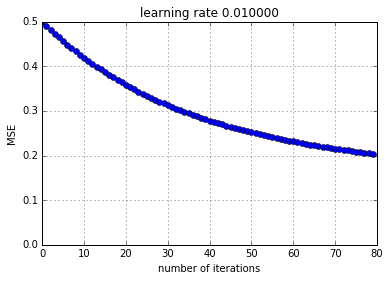

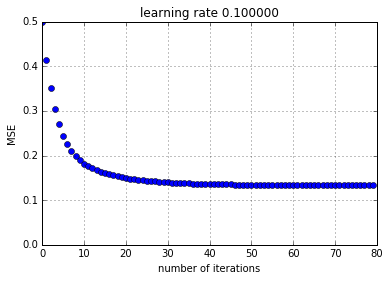

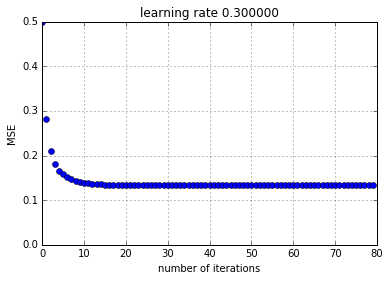

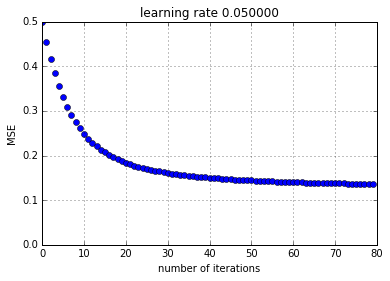

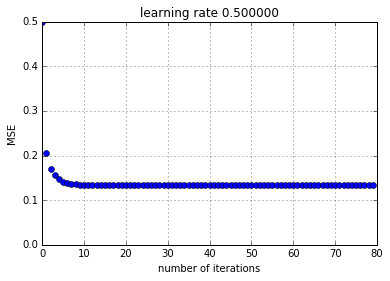

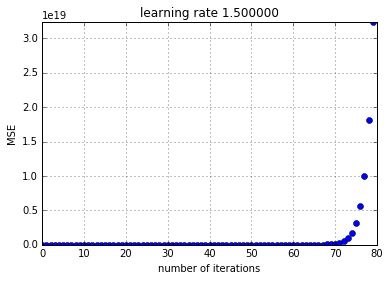

In [7]:
loss_histories = {}
predicted_prices = []
batch_size = N
n_iterations = 80
for lr in (0.01, 0.1, 0.3) + (0.05, 0.5, 1.5):
    W = np.zeros((2, 1))
    bias = np.zeros(1)
    loss_history = train(W, bias, X, Y, N, lr, n_iterations, None)
    pl.figure()
    pl.plot(range(n_iterations), loss_history, 'bo')
    pl.title('learning rate %f' % lr)
    pl.xlabel('number of iterations')
    pl.ylabel('MSE')
    pl.ylim(0, max(loss_history))
    pl.grid()
    print('learning rate %f W0 %f W1 %f W2 %f' % (lr, bias, W[0][0], W[1][0]))
    test_data = np.array([[1650, 3]])
    test_data = (test_data - X_mean) / X_std
    predicted_prices.append(float(predict(W, bias, test_data) * Y_std + Y_mean))
    loss_histories['gradient descent lr=%3f' % lr] = loss_history

### Problem 2 C Predicting Price

In [8]:
for p in predicted_prices: print(p)

311875.8733640332
293430.1372284299
293081.61816276633
295285.9046460459
293081.4643645915
507952021453485.1


### Problem 2 D Stochastic Gradient Descent

In [9]:
# implement the training strategy detailed in Problem 2 D
loss_history = []
epoch_loss_history = []
W = np.zeros((2, 1))
bias = np.zeros(1)
batch_size = 1
lr = 0.1
X_batches, Y_batches = batches(X, batch_size, cyclic=False), batches(Y, batch_size, cyclic=False)
for X_batch, Y_batch in zip(X_batches, Y_batches):
    loss, cache = forward(W, bias, X_batch, Y_batch)
    dW, dbias = backward(W, bias, X_batch, Y_batch, cache)
    W -= lr * dW
    bias -= lr * dbias
    epoch_loss_history.append(loss)
loss_history.extend(epoch_loss_history)
epoch_loss = sum(epoch_loss_history) / len(epoch_loss_history)
print('epoch 1 loss %f' % epoch_loss)
print('epoch 1 W0 %f W1 %f W2 %f' % (bias, W[0][0], W[1][0]))
for epoch in range(2, 11):
    X_batches = batches(X, batch_size, cyclic=False, shuffle=True)
    Y_batches = batches(Y, batch_size, cyclic=False, shuffle=True)
    epoch_loss_history = []
    for X_batch, Y_batch in zip(X_batches, Y_batches):
        loss, cache = forward(W, bias, X_batch, Y_batch)
        dW, dbias = backward(W, bias, X_batch, Y_batch, cache)
        W -= lr * dW
        bias -= lr * dbias
        epoch_loss_history.append(loss)
    loss_history.extend(epoch_loss_history)
    epoch_loss = sum(epoch_loss_history) / len(epoch_loss_history)
    print('epoch %d loss %f' % (epoch, loss))
    print('epoch %d W0 %f W1 %f W2 %f' % (epoch, bias, W[0][0], W[1][0]))
loss_histories['sgd lr=%f' % lr] = loss_history

epoch 1 loss 0.224772
epoch 1 W0 -0.149622 W1 0.639100 W2 -0.075501
epoch 2 loss 0.848794
epoch 2 W0 -0.213890 W1 0.099591 W2 -0.112253
epoch 3 loss 0.038951
epoch 3 W0 0.366088 W1 -0.414811 W2 -0.453152
epoch 4 loss 0.000076
epoch 4 W0 -0.193286 W1 -0.275703 W2 0.110158
epoch 5 loss 0.049707
epoch 5 W0 -0.271044 W1 -0.448366 W2 -0.049239
epoch 6 loss 0.109200
epoch 6 W0 0.246768 W1 0.405716 W2 -0.461653
epoch 7 loss 0.007607
epoch 7 W0 -0.121924 W1 0.036044 W2 -0.136619
epoch 8 loss 0.361109
epoch 8 W0 -0.089699 W1 0.040532 W2 -0.348220
epoch 9 loss 0.079484
epoch 9 W0 -0.068231 W1 0.066581 W2 -0.208252
epoch 10 loss 0.426541
epoch 10 W0 -0.048797 W1 -0.029035 W2 -0.535728


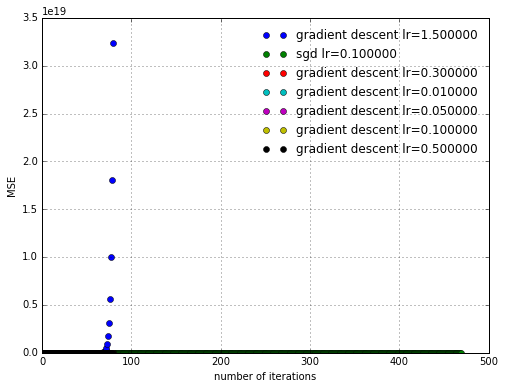

In [10]:
pl.figure(figsize=(8, 6))
for description, loss_history in loss_histories.items():
#     pl.plot(range(80), loss_history[:80], 'o', label=description)
    pl.plot(range(len(loss_history)), loss_history, 'o', label=description)
pl.xlabel('number of iterations')
pl.ylabel('MSE')
pl.legend(framealpha=0, loc='best')
pl.grid()

In [11]:
# test the result of stochastic gradient descent
test_data = np.array([[1650, 3]])
test_data = (test_data - X_mean) / X_std
float(predict(W, bias, test_data) * Y_std + Y_mean)

350961.8247522521

### Comment on model trained by SGD
    SGD may or may not lead to more accurate models compared to normal gradient descent depending on the randomness of shuffling and the choice of learning rate.

### Comment concerning computation time
    It depends on the randomness of shuffling and the choice of learning rate.